# Two samples from torus

In [1]:
using Pkg
Pkg.activate("../env/.")
Pkg.instantiate()

  Activating project at `~/analogous_neural/env`


In [2]:
include("../src/analogous_bars.jl")
include("../src/Eirene_var.jl")

using .analogous_bars
using .Eirene_var


WebIO._IJuliaInit()

In [3]:
using DelimitedFiles
using Plots
using CSV
using Distances
using HDF5
using JLD
using DataStructures

# 1. Load data 

In [4]:
# load
data = load("data/torus_two_samples/data.jld")
P = data["P"] # 3 dimensional coordinates
P_theta = data["P_theta"]
P_phi = data["P_phi"]
Q = data["Q"] # 3 dimensional coordinates
Q_theta = data["Q_theta"]
Q_phi = data["Q_phi"];

print("number of points in P: ", size(P,1), "\n")
print("number of points in Q: ", size(Q,1))

# Assign colors to visualization
P_color = "#ff8d00"
Q_color = "#008181";

number of points in P: 150
number of points in Q: 150

In [5]:
P_2d = hcat(P_theta, P_phi)
Q_2d = hcat(Q_theta, Q_phi);

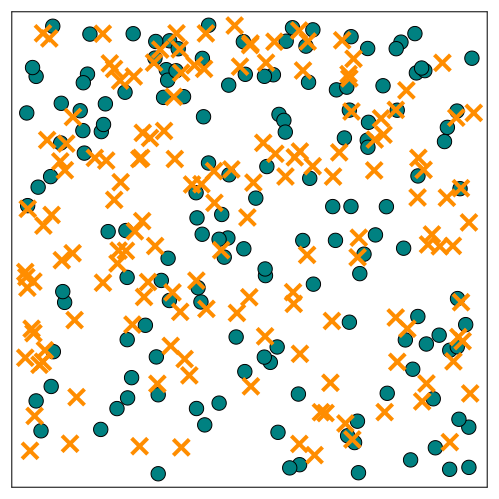

In [7]:
# plot P
p = plot(framestyle = :box, yaxis = nothing, xaxis = nothing,
        size = (500, 500))

scatter!(p,P_2d[:,1], P_2d[:,2], color = "#008181", 
            label = "", 
            markersize = 8, 
            marker = :circle)

# plot Q
scatter!(p, Q_2d[:,1], Q_2d[:,2], color = "#ff8d00", 
            label = "", 
            markersize = 8, 
            marker = :xcross,
            markerstrokewidth = 4
            )
#savefig("data/torus_two_samples/points.pdf")
plot(p)

In [8]:
# compute distance matrices
all_theta = vcat(P_theta, Q_theta)
all_phi = vcat(P_phi, Q_phi);
D = compute_distance_square_torus(all_theta, all_phi)
n = size(P_theta)[1]

# get submatrices
D_P = D[1:n, 1:n]
D_Q = D[n+1:end, n+1:end]
D_P_Q = D[1:n, n+1:end]
D_Q_P = D[n+1:end, 1:n];

In [9]:
# Compute Vietoris-Rips persistence on two regions
dim = 1
VR_P = eirene(D_P, record = "all", maxdim = dim)
VR_Q = eirene(D_Q, record = "all", maxdim = dim)

# compute Witness persistence
W_P = compute_Witness_persistence(D_P_Q, maxdim = dim)
#W_Q = compute_Witness_persistence(D_Q_P, maxdim = dim);

Dict{Any, Any} with 8 entries:
  "fv"                         => Any[Any[0.298624, 0.300983, 0.245756, 0.37429…
  "param_max"                  => 3.93622
  "default_vertex_to_W_vertex" => nothing
  "simplex2index"              => Dict([52, 68, 78]=>395811, [25, 33, 39]=>2266…
  "eirene_output"              => Dict{String, Any}("rv"=>Any[Int64[], [1, 2, 1…
  "index2simplex"              => Dict((478174, 2)=>[74, 75, 99], (259685, 2)=>…
  "distance_matrix"            => [1.56766 2.18854 … 3.28339 2.5611; 2.94152 3.…
  "W_vertex_to_default_vertex" => nothing

In [10]:
# plot all PD
barcode_VR_P = barcode(VR_P, dim = 1)
barcode_W_P = barcode(W_P["eirene_output"], dim = 1)
barcode_VR_Q = barcode(VR_Q, dim = 1);

In [16]:
selected_P, cutoff_P = select_persistent_intervals_IQR(barcode_VR_P)
selected_W, cutoff_W = select_persistent_intervals_IQR(barcode_W_P)
selected_Q, cutoff_Q = select_persistent_intervals_IQR(barcode_VR_Q)


([38, 39, 40], 0.6994212933494263)

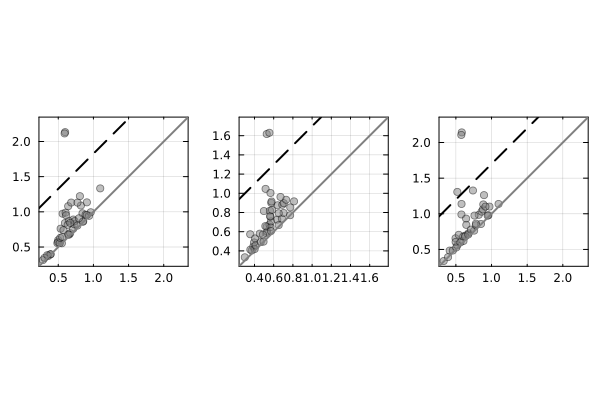

In [20]:
# plot all PD
p1 = plot_PD(barcode_VR_P, cutoff = cutoff_P)
p2 = plot_PD(barcode_W_P, cutoff = cutoff_W)
p3 = plot_PD(barcode_VR_Q, cutoff = cutoff_Q)
plot(p1, p2, p3, layout = grid(1,3))

# Run analogous cycles

In [21]:
analogous_P, analogous_Q, _ = run_baseline_similarity_analogous(;
                                                                VR_P = VR_P,
                                                                D_P = D_P, 
                                                                VR_Q = VR_Q,
                                                                D_Q = D_Q, 
                                                                W_PQ = W_P, 
                                                                W_PQ_bars = selected_W);

In [24]:
significant_P = selected_P
significant_Q = selected_Q

analogous_P1 = [i for i in analogous_P[selected_W[1]]["baseline_bar_extension"] if i in significant_P]
analogous_Q1 = [i for i in analogous_Q[selected_W[1]]["baseline_bar_extension"] if i in significant_Q]
println("Analogous pair: ", analogous_P1, analogous_Q1)

Analogous pair: [47][39, 38]


In [25]:
analogous_P2 = [i for i in analogous_P[selected_W[2]]["baseline_bar_extension"] if i in significant_P]
analogous_Q2 = [i for i in analogous_Q[selected_W[2]]["baseline_bar_extension"] if i in significant_Q]
println("Analogous pair: ", analogous_P2, analogous_Q2)

Analogous pair: [45][40]


So there is one analogous pair, given by (2, 84)

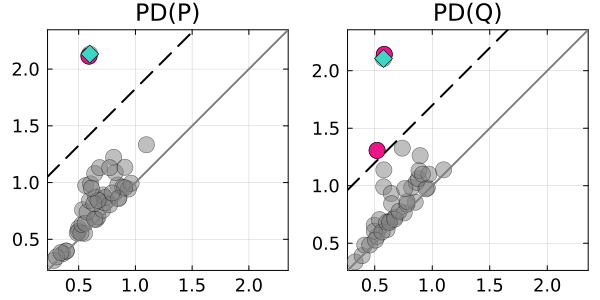

In [71]:
# plot all persistence diagrams & significance feature cutoff
P_idx = [i for i in 1:size(barcode_VR_P,1) if i ∉ [45, 47]]
p1 = plot_PD(barcode_VR_P[P_idx,:]; 
            highlight = [47],
            title = "PD(P)", 
            cutoff = cutoff_P,
            titlefontsize = 16,
            tickfontsize = 12,
            markersize = 9)
scatter!(p1, [barcode_VR_P[45,1]], [barcode_VR_P[45,2]],
            markersize = 9, label = "", 
            markershape = :diamond,
            c = "#3cd7c4")
Q_idx = [i for i in 1:size(barcode_VR_Q,1) if i ∉ [38, 39, 40]]
p2 = plot_PD(barcode_VR_Q[Q_idx,:]; 
            highlight = [38, 39],
            title = "PD(Q)", 
            cutoff = cutoff_Q,
            markersize = 9,
            tickfontsize = 12,
            titlefontsize = 16)
scatter!(p2, [barcode_VR_Q[40,1]], [barcode_VR_Q[40,2]],label ="",
            markersize = 9,
            c = "#3cd7c4",
            markershape = :diamond)

plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/torus_two_samples/analogous_cycles.pdf")

In [14]:
cr_P = get_cyclerep_Eirene(VR_P, 47)
cr_Q_38 = get_cyclerep_Eirene(VR_Q, 38)
cr_Q_39 = get_cyclerep_Eirene(VR_Q, 39)

cr_Q_combined = [cr_Q_38; cr_Q_39]
v = [sort(item) for item in cr_Q_combined]
count = counter(v)
cr_Q = [k for (k,v) in count if v == 1]

p1 = plot_cycle_single_square_torus(P_2d, cycle = cr_P, title = ""; 
                                    legend = false,
                                    markersize = 5,
                                    c = "#008181")
p2 = plot_cycle_single_square_torus(Q_2d, cycle = cr_Q, title = ""; 
                                    markersize = 6, 
                                    marker = :xcross,
                                    markerstrokewidth = 4,
                                    c = "#ff8d00",
                                    legend = false)
plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/torus_two_samples/analogous_cycle_rep.pdf")

"/home/hyoon/analogous_neural/examples/data/torus_two_samples/analogous_cycle_rep.pdf"

In [16]:
cr_P = get_cyclerep_Eirene(VR_P, 45)
cr_Q = get_cyclerep_Eirene(VR_Q, 40)


p1 = plot_cycle_single_square_torus(P_2d, cycle = cr_P, title = ""; 
                                    legend = false,
                                    cycle_color = "#3cd7c4",
                                    markersize = 5,
                                    c = "#008181")
p2 = plot_cycle_single_square_torus(Q_2d, cycle = cr_Q, title = ""; 
                                    markersize = 6, 
                                    marker = :xcross,
                                    cycle_color = "#3cd7c4",
                                    markerstrokewidth = 4,
                                    c = "#ff8d00",
                                    legend = false)

plot(p1, p2, layout = grid(1,2), size = (600, 300))
#savefig("data/torus_two_samples/analogous_cycle_rep_2.pdf")

"/home/hyoon/analogous_neural/examples/data/torus_two_samples/analogous_cycle_rep_2.pdf"